In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd

# Import and merge databases with items. Each item needs category, vectorized description, vectorized image.

### Import list of items for which we have image vectors.

In [2]:
# Item id, category, image-vec path
fullfn = pd.read_csv('data/out.txt', header=None, names='f')
imid = []
imcategory = []
for i in range(0, len(fullfn)):
    imid.append(fullfn.f[i].split('/')[-1])
    imcategory.append(fullfn.f[i].split('/')[-2])

imagenamedf = pd.DataFrame()
imagenamedf['cat'] = imcategory
imagenamedf['id'] = imid

In [3]:
for i in range(0, len(imagenamedf)):
    imagenamedf.id[i] = imagenamedf.id[i].split('.')[0]

In [4]:
fullfn.f[0]

'/home/janelle/files/data/images2/plus_sweaters/HbOpLJoHk2.npy'

### Import description vectors

In [5]:
dnames = ['id','category']
for i in range(1,301):
    dnames.append(str(i))
descriptiondf = pd.read_csv('data/description_vecs.csv',names=dnames)

### Import all image vectors

In [6]:
# Import image vectors
# This takes a little while 

#with open('data/new_allnpy.txt') as ofile:
#    npylines = ofile.readlines()

npylines = pd.read_csv('data/allnpy_22.txt', header=None)
npynames = npylines.columns.tolist()
npynames[0] = 'id'
npylines.columns = npynames
npylines_backup = npylines

In [26]:
# Just need id, not full path

npyid = []
for i in range(0, len(npylines)):
    npyid.append(npylines.id[i].split('.')[0].split('/')[-1])
    
npylines['id'] = npyid

### Use only ids which have both image and description vectors

In [28]:
# Find union of vecs:
bothdf = pd.merge(descriptiondf, npylines, how='inner', on=['id'])

# bothdf.columns[0] is 'id', [1] is 'category', [2:302] is text features, [302:4398] is image features 

### Output to file

In [70]:
# This takes like 30 minutes, don't do this unless needed.
bothdf.to_csv('data/both_vectors.csv')

In [101]:
# Make vectors contained in individual cells?
id_vec = bothdf[bothdf.columns[0:2]]
text_vec = bothdf[bothdf.columns[2:302]]
image_vec = bothdf[bothdf.columns[302:4398]]

### Some visualizations to look at the content of the features (as sanity checks)

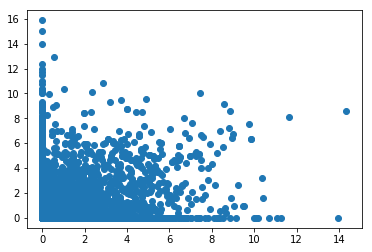

In [26]:
plt.scatter(npylines[0], npylines[1])

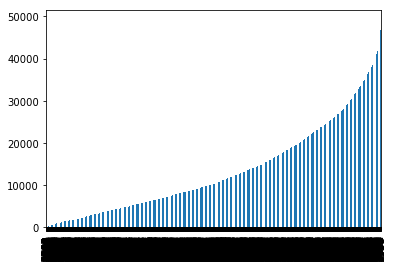

In [53]:
# Plot number of nonzero values for each feature
uniqueXfeature = npylines.nunique()
uniqueXfeatures = uniqueXfeature.sort_values()
uniqueXfeatures.plot.bar()

This looks fine

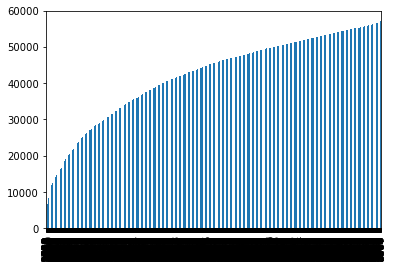

In [67]:
# Plot number of zeros for each feature
numZero = (npylines==0).sum()
numZero = numZero.sort_values()
numZero.plot.bar()

Perhaps remove features that are 0 for over 50%? ~30k

# Output to SQL database

Nope, this isn't working. SQL databases aren't supposed to have so many columns (hard limit on 1600)

In [67]:
dbname = 'intuishop'
username = 'janelleszary'

engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)

postgres://janelleszary@localhost/intuishop


In [68]:
# create a database (if it doesn't exist)
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

True


In [102]:
## insert data into database from Python (proof of concept - this won't be useful for big data, of course)
# bothdf.to_sql('item_data_table', engine, if_exists='replace')